# Dump "Complementary filter"

Attitude estimation is determined from attitude propagation based on Gyro and measurements of tilt, roll and yaw
based on accelerometer and magnetometer, following [ahrs_python:doc](https://ahrs.readthedocs.io/en/latest/filters/complementary.html).

Basic idea is to combine attitude propagation (gyro, $\mathbf{q}_\mathrm{\omega}$) and attitude measurement
(magnetometer and accelormehter, $\mathbf{q}_\mathrm{am}$ with a complementary factor $\alpha$:

$
\mathbf{q} = (1 - \alpha) \mathbf{q}_\omega + \alpha\mathbf{q}_{am}, \quad \alpha \in (0, 1)
$

* yaw angle $\psi$: for North east down frame the angle between north and x axis in horizontal place
* pitch angle $\phi$: angle between horizontal plane and x axis
* roll angle $\theta$:

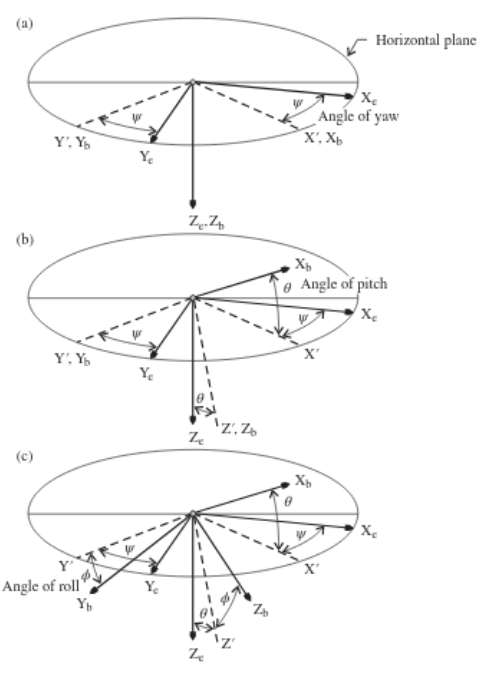

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import sympy
import quaternionic as quat
from scipy.integrate import cumtrapz
from sympy import sin, cos, symbols
from sympy.matrices import rot_axis1, rot_axis2, rot_axis3
from sympy.algebras.quaternion import Quaternion

## Configuration parameters

In [42]:
# num of samples
T = 15 #s
n = 50000

# Gyro
gyro_noise = 0.00
gyro_bias = [0.00] * 3

# Accelerometer
acc_noise = 0.0
acc_bias = [0.0] * 3

# Magnetometer
mag_noise = 0.00
mag_bias = np.zeros(3) #[0.03, 0.02, 0.04]

In [41]:
# num of samples
T = 15 #s
n = 50000

# Gyro
gyro_noise = 0.003
gyro_bias = [0.002, 0.02, 0.01]

# Accelerometer
acc_noise = 0.02
acc_bias = [0.1, 0.07, 0.1]

# Magnetometer
mag_noise = 0.001
mag_bias = np.zeros(3) #[0.03, 0.02, 0.04]

In [56]:
# timesteps between samples
Δt = T / n

# rotation velocities in body frame
ωs = np.zeros((n, 3), dtype=float)
ωs[n//2:,1] = np.sin(np.linspace(0, 2*np.pi, n//2))/25

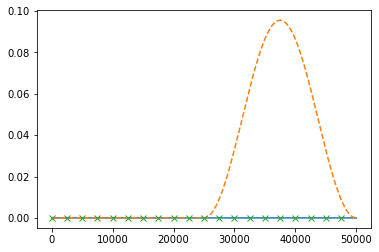

In [57]:
θs = cumtrapz(ωs, dx=Δt, axis=0, initial=0.0)

plt.plot(np.rad2deg(θs[:,0]),'-')
plt.plot(θs[:,1],'--')
plt.plot(θs[:,2],'x', markevery=n//20)

In [58]:
_tmp = np.array([[0.0, 1.0, 0.0]] * n) * θs[:,1][:,np.newaxis]
qs = quat.array.from_axis_angle(_tmp)

## Simulated Measurements

### Gyro

In [59]:
ωs_ = ωs + np.random.normal(gyro_bias, scale=gyro_noise, size=(n,3))

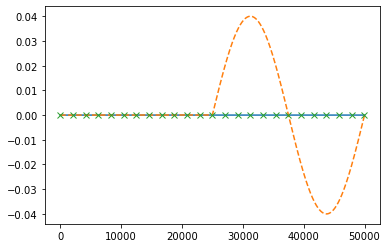

In [60]:
plt.plot(ωs_[:,0])
plt.plot(ωs_[:,1], '--')
plt.plot(ωs_[:,2], 'x', markevery=n//24)

### Accelerometer

In [61]:
g = np.array([0,0,-1])

a = (qs.to_rotation_matrix @ g) \
    + np.random.normal(acc_bias, scale=acc_noise, size=(n, 3))

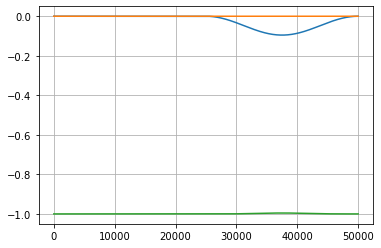

In [62]:
plt.plot(a[:,0])
plt.plot(a[:,1])
plt.plot(a[:,2])
plt.grid()

### Magnetometer

In [63]:
bs_0 = np.array([19355.97, 0, 4495.36]) # values from https://www.geomatrix.co.uk/tools/magnetic-field-calculator/
bs_0 = bs_0 / np.linalg.norm(bs_0)

ms = qs.to_rotation_matrix @ bs_0  \
    + np.random.normal(mag_bias, scale=mag_noise, size=(n,3))

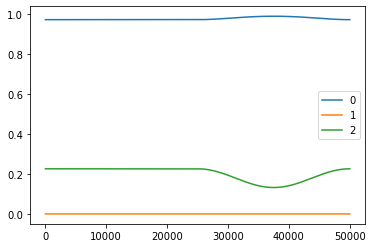

In [64]:
plt.plot(ms[:,0], label='0')
plt.plot(ms[:,1], label='1')
plt.plot(ms[:,2], label='2')

plt.legend();

## Filter

In [65]:
from ahrs.filters import Madgwick

In [66]:
madgwick = Madgwick(ωs_, a, Dt=Δt)

In [67]:
madgwick.Dt

0.0003

In [68]:
qs_ = quat.array(madgwick.Q)

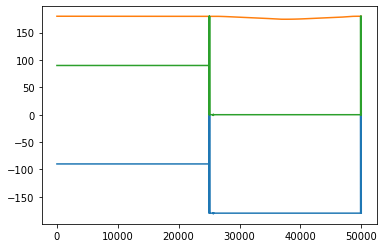

In [70]:
plt.plot(np.rad2deg(qs_.to_euler_angles))